<a href="https://colab.research.google.com/github/shweteekta/100-Days-of-ML-Code-/blob/master/Style_Transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#!pip install torch
from __future__ import print_function

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
import torchvision.models as models

import copy

In [2]:
!wget -O content.jpg https://raw.githubusercontent.com/anishathalye/neural-style/master/examples/2-content.jpg
!wget -O style.jpg https://raw.githubusercontent.com/anishathalye/neural-style/master/examples/2-style2.jpg

--2019-10-03 19:45:25--  https://raw.githubusercontent.com/anishathalye/neural-style/master/examples/2-content.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 120188 (117K) [image/jpeg]
Saving to: ‘content.jpg’

content.jpg         100%[===================>] 117.37K  --.-KB/s    in 0.03s   

2019-10-03 19:45:26 (3.84 MB/s) - ‘content.jpg’ saved [120188/120188]

--2019-10-03 19:45:28--  https://raw.githubusercontent.com/anishathalye/neural-style/master/examples/2-style2.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 107366 (105K) [i

In [0]:
from PIL import Image
#style_img = Image.open('style.jpg')
#content_img = Image.open('content.jpg') 

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
cnn = models.vgg19(pretrained=True).features.to(device).eval()
imsize = 512 if torch.cuda.is_available() else 128
width = 192
height = 128

loader = transforms.Compose([
    transforms.Resize(imsize), 
    transforms.ToTensor()])  

def image_loader(image_name):
    image = Image.open(image_name)
    image = image.resize((width, height), Image.NEAREST)      # use nearest neighbour

    image = loader(image).unsqueeze(0)
    return image.to(device, torch.float)


style_img = image_loader("style.jpg")
content_img = image_loader("content.jpg")
print(content_img.size())
print(style_img.size())

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:05<00:00, 103MB/s] 


torch.Size([1, 3, 512, 768])
torch.Size([1, 3, 512, 768])


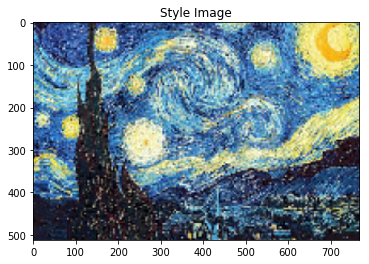

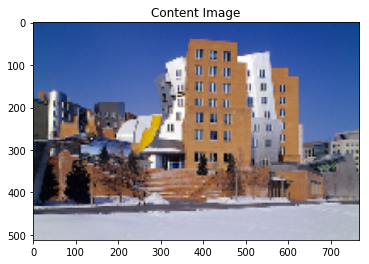

In [6]:
unloader = transforms.ToPILImage() 
plt.ion()

def imshow(tensor, title=None):
    image = tensor.cpu().clone() 
    image = image.squeeze(0)      
    image = unloader(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) 

plt.figure()
imshow(style_img, title='Style Image')

plt.figure()
imshow(content_img, title='Content Image')

In [0]:
class ContentLoss(nn.Module):

    def __init__(self, target,):
        super(ContentLoss, self).__init__()
        self.target = target.detach()

    def forward(self, input):
        self.loss = F.mse_loss(input, self.target)
        return input

In [0]:
def gram_matrix(input):
    a, b, c, d = input.size()  

    features = input.view(a * b, c * d)  # resise F_XL into \hat F_XL

    G = torch.mm(features, features.t()) 

    return G.div(a * b * c * d)


In [0]:
class StyleLoss(nn.Module):

    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = gram_matrix(target_feature).detach()

    def forward(self, input):
        G = gram_matrix(input)
        self.loss = F.mse_loss(G, self.target)
        return input

In [0]:
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        self.mean = torch.tensor(mean).view(-1, 1, 1)
        self.std = torch.tensor(std).view(-1, 1, 1)

    def forward(self, img):
        return (img - self.mean) / self.std

In [0]:
content_layers_default = ['conv_4']
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

def get_style_model_and_losses(cnn, normalization_mean, normalization_std,
                               style_img, content_img,
                               content_layers=content_layers_default,
                               style_layers=style_layers_default):
    cnn = copy.deepcopy(cnn)

    normalization = Normalization(normalization_mean, normalization_std).to(device)

    content_losses = []
    style_losses = []

    model = nn.Sequential(normalization)

    i = 0  
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_{}'.format(i)
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(i)
          
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_{}'.format(i)
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}'.format(i)
        else:
            raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

        model.add_module(name, layer)

        if name in content_layers:
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module("content_loss_{}".format(i), content_loss)
            content_losses.append(content_loss)

        if name in style_layers:
            target_feature = model(style_img).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module("style_loss_{}".format(i), style_loss)
            style_losses.append(style_loss)
            
    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break

    model = model[:(i + 1)]
    return model, style_losses, content_losses

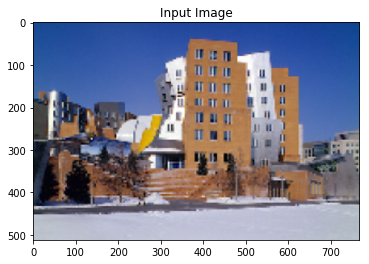

In [12]:
input_img = content_img.clone()
plt.figure()
imshow(input_img, title='Input Image')

In [0]:
def get_input_optimizer(input_img):
    optimizer = optim.LBFGS([input_img.requires_grad_()])
    return optimizer

In [0]:
def run_style_transfer(cnn, normalization_mean, normalization_std,
                       content_img, style_img, input_img, num_steps=300,
                       style_weight=1000000, content_weight=1):
   
    model, style_losses, content_losses = get_style_model_and_losses(cnn,
        normalization_mean, normalization_std, style_img, content_img)
    optimizer = get_input_optimizer(input_img)

    print('Optimizing..')
    run = [0]
    while run[0] <= num_steps:

        def closure():
            # correct the values of updated input image
            input_img.data.clamp_(0, 1)

            optimizer.zero_grad()
            model(input_img)
            style_score = 0
            content_score = 0

            for sl in style_losses:
                style_score += sl.loss
            for cl in content_losses:
                content_score += cl.loss

            style_score *= style_weight
            content_score *= content_weight

            loss = style_score + content_score
            loss.backward()

            run[0] += 1
            if run[0] % 50 == 0:
                print("run {}:".format(run))
                print('Style Loss : {:4f} Content Loss: {:4f}'.format(
                    style_score.item(), content_score.item()))
                print()

            return style_score + content_score

        optimizer.step(closure)

  
    input_img.data.clamp_(0, 1)

    return input_img

In [15]:
output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style_img, input_img)




/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


Optimizing..
run [50]:
Style Loss : 42.830643 Content Loss: 12.431313

run [100]:
Style Loss : 10.772403 Content Loss: 12.738200

run [150]:
Style Loss : 6.534694 Content Loss: 12.308175

run [200]:
Style Loss : 4.873050 Content Loss: 11.800435

run [250]:
Style Loss : 3.729950 Content Loss: 11.563846

run [300]:
Style Loss : 3.173773 Content Loss: 11.563431



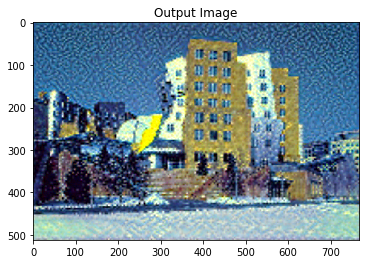

In [16]:

plt.figure()
imshow(output, title='Output Image')
#plt.imshow(output)

plt.ioff()
plt.show()
